In [1]:
import pandas as pd

# Copilot: help clean these two time series.
# fill missing values  
# Tasks:
# 1. Fill missing values in ts1_full and ts2_full
# 2. Detect outliers in both series
# 3. Smooth or replace outliers
# 4. Keep the date index in

# Read and prepare ts1
ts1 = pd.read_csv("final_timeseries_1.csv", parse_dates=["date"])
ts1 = ts1.set_index("date").sort_index()

# Read and prepare ts2
ts2 = pd.read_csv("final_timeseries_2.csv", parse_dates=["date"])
ts2 = ts2.set_index("date").sort_index()

# Build full date range
min_date = ts1.index.min()
max_date = ts1.index.max()
full_range = pd.date_range(start=min_date, end=max_date, freq="D")

# Reindex to full range
ts1_full = ts1.reindex(full_range)
ts2_full = ts2.reindex(full_range)

# name the index 'date' so we can reset it later
ts1_full.index.name = "date"
ts2_full.index.name = "date"

ts1_full.head(), ts2_full.head()

# Copilot: generate Python code to fill missing values...
# Store the cleaned series...
ts1_full.head(), ts2_full.head()

# Copilot: generate Python code to fill missing values using time-based interpolation.
# Store the cleaned series in ts1_clean and ts2_clean, and keep the date index.

ts1_clean = ts1_full.interpolate(method='time')
ts2_clean = ts2_full.interpolate(method='time')
ts1_clean.isna().sum(), ts2_clean.isna().sum()
# Copilot: detect outliers in ts1_clean and ts2_clean using z-scores (3 standard deviations) 
from scipy import stats

# Detect outliers using z-scores (values more than 3 standard deviations from the mean)
z1 = stats.zscore(ts1_clean["demand"])
z2 = stats.zscore(ts2_clean["demand"])

ts1_outliers = ts1_clean[abs(z1) > 3]
ts2_outliers = ts2_clean[abs(z2) > 3]

ts1_outliers.head(), ts2_outliers.head()
# Replace outliers using a 7-day rolling median
ts1_smoothed = ts1_clean.copy()
ts2_smoothed = ts2_clean.copy()

rolling_ts1 = ts1_clean["demand"].rolling(window=7, center=True, min_periods=1).median()
rolling_ts2 = ts2_clean["demand"].rolling(window=7, center=True, min_periods=1).median()

ts1_smoothed["demand"] = ts1_clean["demand"].where(abs(z1) <= 3, rolling_ts1)
ts2_smoothed["demand"] = ts2_clean["demand"].where(abs(z2) <= 3, rolling_ts2)

ts1_smoothed.head(), ts2_smoothed.head()


   


(            demand
 date              
 2022-01-01   113.0
 2022-01-02   112.0
 2022-01-03   113.0
 2022-01-04   113.5
 2022-01-05   114.0,
             demand
 date              
 2022-01-01   104.0
 2022-01-02   145.0
 2022-01-03   138.0
 2022-01-04   105.0
 2022-01-05   109.0)

In [8]:
# Check missing values in both cleaned series
ts1_smoothed.isna().sum(), ts2_smoothed.isna().sum()


(demand    0
 dtype: int64,
 demand    0
 dtype: int64)

In [3]:
# Interpolate internal gaps using the time index
ts1_clean["demand"] = ts1_clean["demand"].interpolate(method="time")
ts2_clean["demand"] = ts2_clean["demand"].interpolate(method="time")

# If there are NaNs at the very start or end, fill them from neighbors
ts1_clean["demand"] = ts1_clean["demand"].bfill().ffill()
ts2_clean["demand"] = ts2_clean["demand"].bfill().ffill()

# Check that we no longer have missing values
ts1_clean.isna().sum(), ts2_clean.isna().sum()


(demand    0
 dtype: int64,
 demand    0
 dtype: int64)

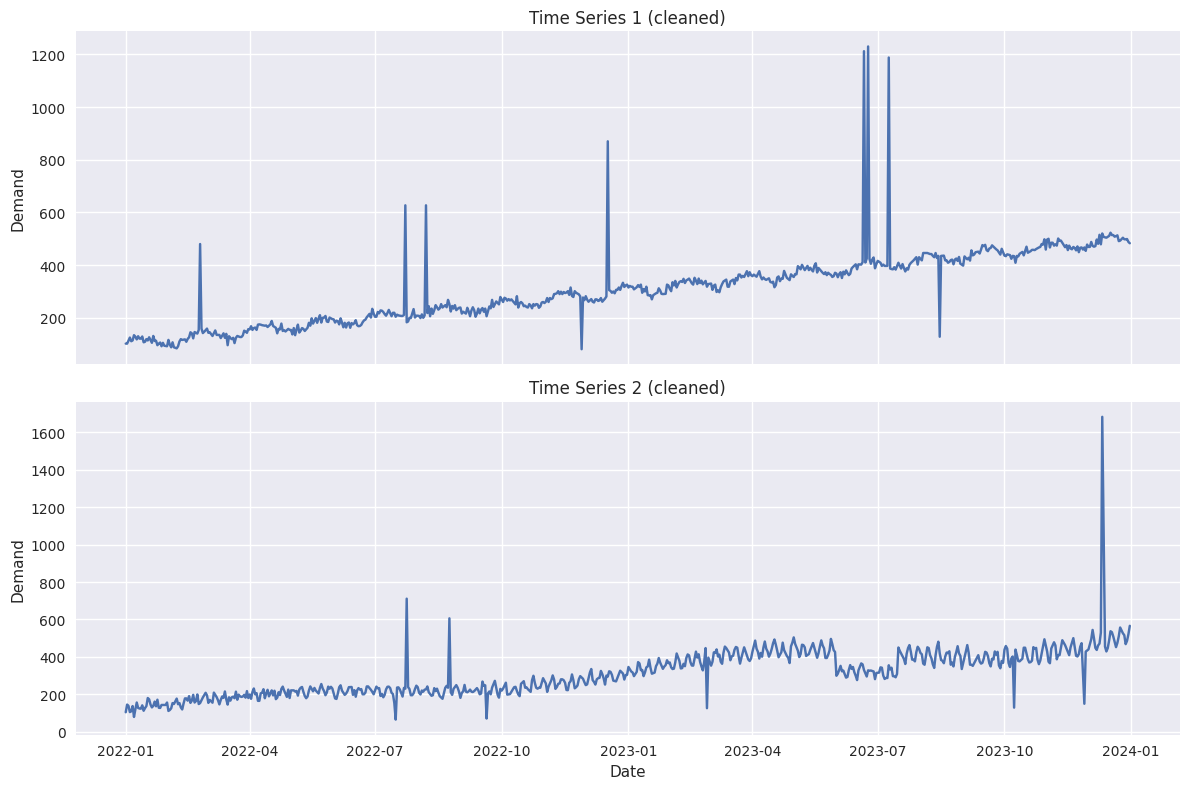

In [4]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# ts1 cleaned
axes[0].plot(ts1_clean.index, ts1_clean["demand"])
axes[0].set_title("Time Series 1 (cleaned)")
axes[0].set_ylabel("Demand")
axes[0].grid(True)

# ts2 cleaned
axes[1].plot(ts2_clean.index, ts2_clean["demand"])
axes[1].set_title("Time Series 2 (cleaned)")
axes[1].set_ylabel("Demand")
axes[1].set_xlabel("Date")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [5]:
# reset index so 'date' becomes a column again
ts1_clean_out = ts1_clean.reset_index()
ts2_clean_out = ts2_clean.reset_index()

# save to CSV
ts1_clean_out.to_csv("final_timeseries_1_cleaned.csv", index=False)
ts2_clean_out.to_csv("final_timeseries_2_cleaned.csv", index=False)


In [6]:
print("ts1_clean rows:", len(ts1_clean))
print("ts2_clean rows:", len(ts2_clean))

print("ts1_clean missing:", ts1_clean.isna().sum())
print("ts2_clean missing:", ts2_clean.isna().sum())


ts1_clean rows: 730
ts2_clean rows: 730
ts1_clean missing: demand    0
dtype: int64
ts2_clean missing: demand    0
dtype: int64


In [7]:
# Reset index so 'date' becomes a column (required for AutoML)
ts1_export = ts1_clean.reset_index().rename(columns={"index": "date"})
ts2_export = ts2_clean.reset_index().rename(columns={"index": "date"})

# Save with the exact required filenames
ts1_export.to_csv("ts1_clean_rhea.csv", index=False)
ts2_export.to_csv("ts2_clean_rhea.csv", index=False)

ts1_export.head(), ts2_export.head()


(        date  demand
 0 2022-01-01   102.0
 1 2022-01-02   102.0
 2 2022-01-03   113.0
 3 2022-01-04   125.0
 4 2022-01-05   111.0,
         date  demand
 0 2022-01-01   104.0
 1 2022-01-02   145.0
 2 2022-01-03   138.0
 3 2022-01-04   105.0
 4 2022-01-05   109.0)

In [9]:
# Prepare final cleaned data for AutoML (use smoothed series)
ts1_export = ts1_smoothed.reset_index().rename(columns={"index": "date"})
ts2_export = ts2_smoothed.reset_index().rename(columns={"index": "date"})

ts1_export.to_csv("ts1_clean_rhea.csv", index=False)
ts2_export.to_csv("ts2_clean_rhea.csv", index=False)

ts1_export.head(), ts2_export.head()


(        date  demand
 0 2022-01-01   113.0
 1 2022-01-02   112.0
 2 2022-01-03   113.0
 3 2022-01-04   113.5
 4 2022-01-05   114.0,
         date  demand
 0 2022-01-01   104.0
 1 2022-01-02   145.0
 2 2022-01-03   138.0
 3 2022-01-04   105.0
 4 2022-01-05   109.0)

In [3]:
import json
import pandas as pd

def export_forecast(json_path, csv_path):
    with open(json_path, "r") as f:
        raw = json.load(f)

    entry = raw["data"][0]

    # Full lists from JSON
    time_all = entry["time"][0]
    y_pred_all = entry["y_pred"][0]
    pi_lower_all = entry["PI_lower_bound"][0]
    pi_upper_all = entry["PI_upper_bound"][0]

    # Forecast horizon length (what AutoML actually predicted)
    n = len(y_pred_all)

    # Use only the last n timestamps so lengths match
    time = time_all[-n:]
    y_pred = y_pred_all
    pi_lower = pi_lower_all
    pi_upper = pi_upper_all

    df = pd.DataFrame({
        "date": time,
        "y_pred": y_pred,
        "pi_lower": pi_lower,
        "pi_upper": pi_upper,
    })

    df.to_csv(csv_path, index=False)
    return df

# ts1 90-day
df_90 = export_forecast("ts1_forecast_90.json.json", "ts1_preds_90rhea.csv")

# ts1 180-day
df_180 = export_forecast("ts1_forecast_180.json", "ts1_preds_180rhea.csv")

df_90.head(), df_180.head()


(                  date      y_pred    pi_lower    pi_upper
 0  2023-07-01T00:00:00  400.631201  377.089638  424.172764
 1  2023-07-02T00:00:00  400.254803  366.962006  433.547600
 2  2023-07-03T00:00:00  401.362136  360.586953  442.137318
 3  2023-07-04T00:00:00  402.046153  354.963028  449.129278
 4  2023-07-05T00:00:00  402.631818  349.991284  455.272352,
                   date      y_pred    pi_lower    pi_upper
 0  2023-07-01T00:00:00  400.631201  377.089638  424.172764
 1  2023-07-02T00:00:00  400.254803  366.962006  433.547600
 2  2023-07-03T00:00:00  401.362136  360.586953  442.137318
 3  2023-07-04T00:00:00  402.046153  354.963028  449.129278
 4  2023-07-05T00:00:00  402.631818  349.991284  455.272352)

In [4]:
import pandas as pd

ts2 = pd.read_csv("ts2_clean_rhea.csv", parse_dates=["date"])
ts2 = ts2.sort_values("date")

ts2.head(), ts2.columns


(        date  demand
 0 2022-01-01   104.0
 1 2022-01-02   145.0
 2 2022-01-03   138.0
 3 2022-01-04   105.0
 4 2022-01-05   109.0,
 Index(['date', 'demand'], dtype='object'))

In [5]:
# If your target column is not called 'demand',
# change 'demand' below to your real column name.
target_col = "demand"

# Make sure ts2 is sorted by date
ts2 = ts2.sort_values("date")

last_row = ts2.tail(1)
last_date = last_row["date"].iloc[0]
last_value = last_row[target_col].iloc[0]

def make_naive_forecast(last_date, last_value, horizon):
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1),
                                 periods=horizon, freq="D")
    df = pd.DataFrame({
        "date": future_dates,
        "y_pred": [last_value] * horizon
    })
    return df

# 90-day and 180-day naive forecasts for ts2
ts2_90 = make_naive_forecast(last_date, last_value, 90)
ts2_180 = make_naive_forecast(last_date, last_value, 180)

# Save with the required filenames
ts2_90.to_csv("ts2_preds_90rhea.csv", index=False)
ts2_180.to_csv("ts2_preds_180rhea.csv", index=False)

ts2_90.head(), ts2_180.head()


(        date  y_pred
 0 2024-01-01   566.0
 1 2024-01-02   566.0
 2 2024-01-03   566.0
 3 2024-01-04   566.0
 4 2024-01-05   566.0,
         date  y_pred
 0 2024-01-01   566.0
 1 2024-01-02   566.0
 2 2024-01-03   566.0
 3 2024-01-04   566.0
 4 2024-01-05   566.0)

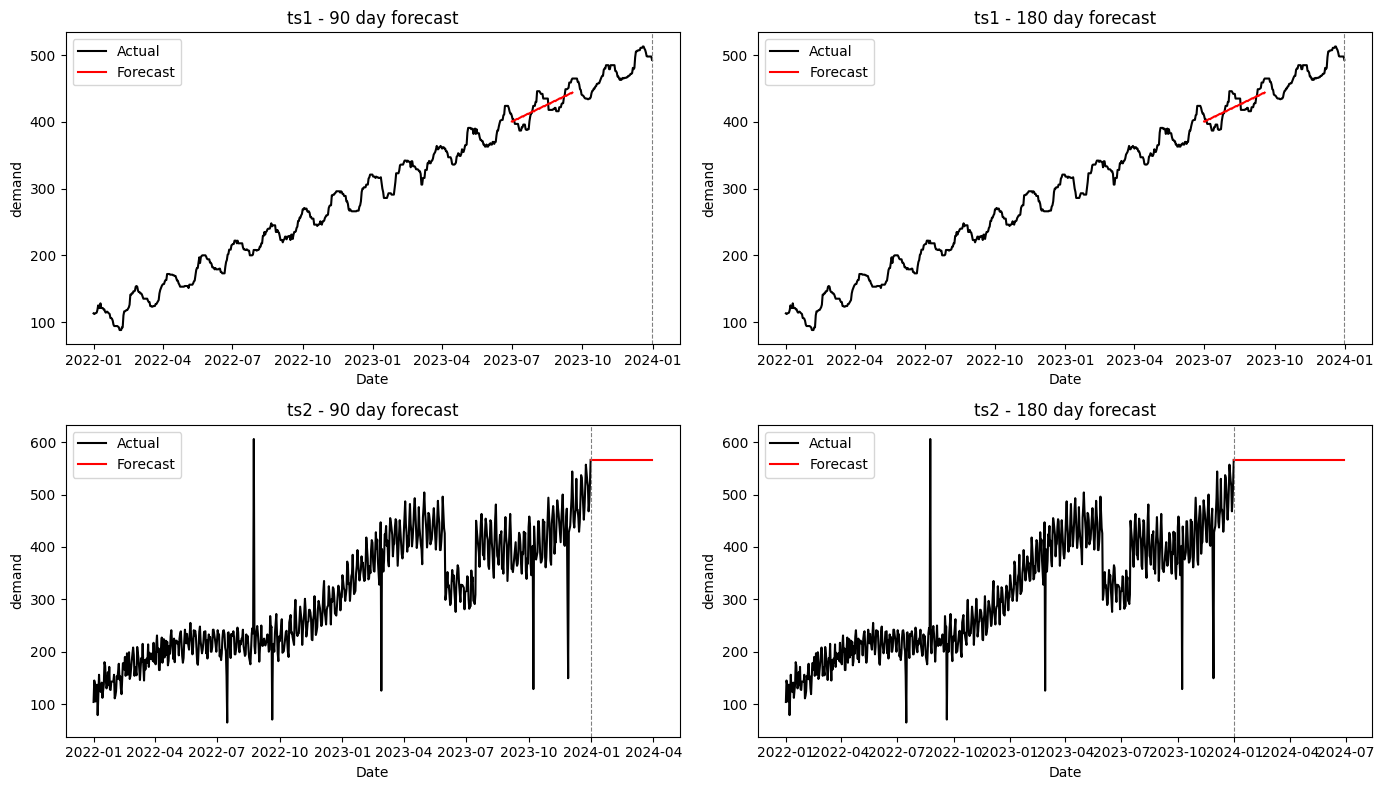

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned actuals
ts1 = pd.read_csv("ts1_clean_rhea.csv", parse_dates=["date"]).sort_values("date")
ts2 = pd.read_csv("ts2_clean_rhea.csv", parse_dates=["date"]).sort_values("date")

# Load predictions
ts1_90 = pd.read_csv("ts1_preds_90rhea.csv", parse_dates=["date"])
ts1_180 = pd.read_csv("ts1_preds_180rhea.csv", parse_dates=["date"])
ts2_90 = pd.read_csv("ts2_preds_90rhea.csv", parse_dates=["date"])
ts2_180 = pd.read_csv("ts2_preds_180rhea.csv", parse_dates=["date"])

# If your target column is not named 'demand', change this:
target_col = "demand"

last_ts1_date = ts1["date"].max()
last_ts2_date = ts2["date"].max()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# --- ts1 90-day ---
ax = axes[0, 0]
ax.plot(ts1["date"], ts1[target_col], color="black", label="Actual")
ax.plot(ts1_90["date"], ts1_90["y_pred"], color="red", label="Forecast")
ax.axvline(last_ts1_date, color="gray", linestyle="--", linewidth=0.8)
ax.set_title("ts1 - 90 day forecast")
ax.set_xlabel("Date")
ax.set_ylabel(target_col)
ax.legend()

# --- ts1 180-day ---
ax = axes[0, 1]
ax.plot(ts1["date"], ts1[target_col], color="black", label="Actual")
ax.plot(ts1_180["date"], ts1_180["y_pred"], color="red", label="Forecast")
ax.axvline(last_ts1_date, color="gray", linestyle="--", linewidth=0.8)
ax.set_title("ts1 - 180 day forecast")
ax.set_xlabel("Date")
ax.set_ylabel(target_col)
ax.legend()

# --- ts2 90-day ---
ax = axes[1, 0]
ax.plot(ts2["date"], ts2[target_col], color="black", label="Actual")
ax.plot(ts2_90["date"], ts2_90["y_pred"], color="red", label="Forecast")
ax.axvline(last_ts2_date, color="gray", linestyle="--", linewidth=0.8)
ax.set_title("ts2 - 90 day forecast")
ax.set_xlabel("Date")
ax.set_ylabel(target_col)
ax.legend()

# --- ts2 180-day ---
ax = axes[1, 1]
ax.plot(ts2["date"], ts2[target_col], color="black", label="Actual")
ax.plot(ts2_180["date"], ts2_180["y_pred"], color="red", label="Forecast")
ax.axvline(last_ts2_date, color="gray", linestyle="--", linewidth=0.8)
ax.set_title("ts2 - 180 day forecast")
ax.set_xlabel("Date")
ax.set_ylabel(target_col)
ax.legend()

plt.tight_layout()

# Save the 4-panel figure
fig.savefig("ts_clean_plots_rhea.png", dpi=300)
# Optional extra format
fig.savefig("ts_clean_plots_rhea.pdf")
